input JSON file path

In [122]:
input_json = r"C:\Users\Soushiyant\Desktop\input.json"

Import

In [123]:
import json
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
from random import sample
from copy import deepcopy
from itertools import combinations

In [124]:
Image_out = False

#Define the Hyperparameters
nGene = 12
gene_Domain = [0,2000]        #landscape size for center of building
nObjectives = 2               #number of Objectives
nPop = 100                  #number of Population
nCrossover = 80              #number of Crossover
nMutation = 20                #number of Mutation
nGeneration = 100

alpha = 0.5
beta = 10

#open JSON file
with open(input_json, 'r') as file:
    data = json.load(file)

NUM_BUILDINGS = len(data["buildings"])
NUM_Paths = len(data["paths"])
print(f"Buildings: {NUM_BUILDINGS} \nPaths: {NUM_Paths}")

#first generation
main_genome =  np.random.randint(gene_Domain[0], gene_Domain[1], ) 

Buildings: 4 
Paths: 2


In [125]:
def calculate_total_bounding_box(rectangles):

    min_x = min(rect.bounds[0] for rect in rectangles)
    min_y = min(rect.bounds[1] for rect in rectangles)
    max_x = max(rect.bounds[2] for rect in rectangles)
    max_y = max(rect.bounds[3] for rect in rectangles)

    return (min_x, min_y, max_x, max_y)

In [126]:
json_out = []


def generate_solution_json(pop, data):
    solutions = []

    for arrangement_id, agent in enumerate(pop, start=1):

        x_vector = agent.genome[0:4]
        y_vector = agent.genome[4:8]
        flip = agent.genome[9:13]
        flip = [0 if val <= gene_Domain[1] / 2 else 1 for val in flip]

        buildings = []
        for i, building in enumerate(data["buildings"]):
            dim = building["dimensions"]
            if flip[i]:
                dim = list(reversed(dim))
            buildings.append({
                "name": building["name"],
                "location": [x_vector[i], y_vector[i]],
                "dimensions": dim
            })

        # Prepare path data
        paths = []
        for i, path in enumerate(data["paths"]): 
            paths.append({
                "name": path["name"],
                "connected_buildings": path["between"]
            })


        solutions.append({
            "arrangement_id": arrangement_id,
            "buildings": buildings,
            "paths": paths,
            "objectives": {
                "objective": agent.fitness,  

            }
        })

    json_out.append(solutions)







In [127]:
def calculate_objectives(data, main_genome):

    #Creat genome
    x_vector = main_genome[0:4]
    y_vector = main_genome[4:8]
    flip = main_genome[9:13]
    flip[flip <= gene_Domain[1]/2] = 0
    flip[flip > gene_Domain[1]/2] = 1

    outgenome = [list(x_vector), list(y_vector), list(flip)]

    # Initialization
    rectangles = []
    buildings_moved = []
    x_y = []
    penalty_bbox = 0
    NUM_BUILDINGS = len(data["buildings"])

    # Create rectangles for buildings
    for i in range(NUM_BUILDINGS):
        dim_rect = data['buildings'][i]["dimensions"]
        if flip[i]:
            dim_rect = list(reversed(dim_rect))
        rectangles.append(np.array([dim_rect[0] / 2 * -1, dim_rect[1] / 2 * -1, dim_rect[0] / 2, dim_rect[1] / 2]))

    # Move buildings based on vectors
    for i in range(NUM_BUILDINGS):
        vector = np.array([x_vector[i], y_vector[i], x_vector[i], y_vector[i]])
        moved_rectangle = rectangles[i] + vector
        x_y.append(moved_rectangle.tolist())
        buildings_moved.append(box(*moved_rectangle))

    # Calculate total bounding box
    bbox = calculate_total_bounding_box(buildings_moved)
    area_bbox = box(*bbox).area
    print("area: ",area_bbox)
    # Check for intersections and calculate penalties
    for i, rect1 in enumerate(buildings_moved):
        for j, rect2 in enumerate(buildings_moved):
            if i >= j:
                continue
            if rect1.intersects(rect2):
                print(f"Building {i + 1} and building {j + 1} have intersect")
                penalty_bbox += 1

    obj1 = penalty_bbox * 1000000000 + area_bbox

    # Path calculations
    penalty_path_exist = 0
    path_from = []
    path_to = []
    road_size = []
    path_shape = []
    roads = []

    for i in range(len(data["paths"])):
        path_from.append(buildings_moved[int(data["paths"][i]["between"][0][-1]) - 1])
        path_to.append(buildings_moved[int(data["paths"][i]["between"][1][-1]) - 1])

    for j in range(len(data["paths"])):
        xmin_xmin = path_from[j].bounds[0] < path_to[j].bounds[0]
        xmax_xmax = path_from[j].bounds[2] < path_to[j].bounds[2]
        ymin_ymin = path_from[j].bounds[1] < path_to[j].bounds[1]
        ymax_ymax = path_from[j].bounds[3] < path_to[j].bounds[3]

        xmin_xmax = path_from[j].bounds[0] < path_to[j].bounds[2]
        xmax_xmin = path_from[j].bounds[2] < path_to[j].bounds[0]
        ymin_ymax = path_from[j].bounds[1] < path_to[j].bounds[3]
        ymax_ymin = path_from[j].bounds[3] < path_to[j].bounds[1]

        # path type 1 -4

        if xmin_xmin and not xmax_xmax and xmin_xmax and not xmax_xmin and ymin_ymin and ymax_ymax and ymin_ymax and ymax_ymin:
            path_shape.append([path_to[j].bounds[2], path_from[j].bounds[3], path_to[j].bounds[2] + data["paths"][j]["width"], path_to[j].bounds[3]])
            print("road type :1")

        elif not xmin_xmin and not xmax_xmax and not xmin_xmax and not xmax_xmin and ymin_ymin and not ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[0] ,path_to[j].bounds[3], path_from[j].bounds[0], path_to[j].bounds[3]+data["paths"][j]["width"]])
            print("road type :2")
        
        elif xmin_xmin and xmax_xmax and xmin_xmax and xmax_xmin and ymin_ymin and not ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_from[j].bounds[2] ,path_to[j].bounds[1] -data["paths"][j]["width"], path_to[j].bounds[2], path_to[j].bounds[1]])
            print("road type :3")

        elif xmin_xmin and not xmax_xmax and xmin_xmax and not xmax_xmin and not ymin_ymin and not ymax_ymax and not ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[2] -data["paths"][j]["width"], path_to[j].bounds[1], path_to[j].bounds[2], path_from[j].bounds[1]])
            print("road type :4")
        
        # path type 5 -12

        elif not xmin_xmin and not xmax_xmax and xmin_xmax and not xmax_xmin and ymin_ymin and ymax_ymax and ymin_ymax and ymax_ymin:
            path_shape.append([path_to[j].bounds[2], path_from[j].bounds[3], path_to[j].bounds[2]+data["paths"][j]["width"], path_to[j].bounds[3]])
            print("road type :5")
        
        elif xmin_xmin and xmax_xmax and xmin_xmax and not xmax_xmin and ymin_ymin and ymax_ymax and ymin_ymax and ymax_ymin:
            path_shape.append([path_to[j].bounds[0]-data["paths"][j]["width"], path_from[j].bounds[3], path_to[j].bounds[0], path_to[j].bounds[3]])
            print("road type :6")

        elif not xmin_xmin and not xmax_xmax and not xmin_xmax and not xmax_xmin and ymin_ymin and ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[0], path_to[j].bounds[1]-data["paths"][j]["width"], path_from[j].bounds[0], path_to[j].bounds[1]])
            print("road type :7")

        elif xmin_xmin and xmax_xmax and xmin_xmax and xmax_xmin and ymin_ymin and ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_from[j].bounds[2], path_to[j].bounds[1], path_to[j].bounds[2], path_to[j].bounds[1]+data["paths"][j]["width"]])
            print("road type :8")

        elif not xmin_xmin and not xmax_xmax and not xmin_xmax and not xmax_xmin and not ymin_ymin and not ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[0], path_to[j].bounds[3], path_from[j].bounds[0], path_to[j].bounds[3]+data["paths"][j]["width"]])
            print("road type :9")

        elif xmin_xmin and xmax_xmax and xmin_xmax and xmax_xmin and not ymin_ymin and not ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_from[j].bounds[2], path_to[j].bounds[3], path_to[j].bounds[2], path_to[j].bounds[3]+data["paths"][j]["width"]])
            print("road type :10")

        elif not xmin_xmin and not xmax_xmax and xmin_xmax and not xmax_xmin and not ymin_ymin and not ymax_ymax and not ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[2], path_to[j].bounds[1], path_to[j].bounds[2]+data["paths"][j]["width"], path_from[j].bounds[1]])
            print("road type :11")

        elif xmin_xmin and xmax_xmax and xmin_xmax and not xmax_xmin and not ymin_ymin and not ymax_ymax and not ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[0]-data["paths"][j]["width"], path_to[j].bounds[1], path_to[j].bounds[0], path_from[j].bounds[1]])
            print("road type :12")

        # path type 13 -16

        elif not xmin_xmin and xmax_xmax and xmin_xmax and not xmax_xmin and ymin_ymin and ymax_ymax and ymin_ymax and ymax_ymin:
            path_shape.append([path_from[j].bounds[2], path_from[j].bounds[1], path_from[j].bounds[2]+data["paths"][j]["width"], path_to[j].bounds[0]])
            print("road type :13")

        elif not xmin_xmin and not xmax_xmax and not xmin_xmax and not xmax_xmin and not ymin_ymin and ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[2], path_from[j].bounds[3], path_from[j].bounds[2], path_from[j].bounds[3]+data["paths"][j]["width"]])
            print("road type :14")

        elif xmin_xmin and xmax_xmax and xmin_xmax and xmax_xmin and not ymin_ymin and ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_from[j].bounds[0], path_from[j].bounds[1]-data["paths"][j]["width"], path_to[j].bounds[0], path_from[j].bounds[1]])
            print("road type :15")

        elif not xmin_xmin and xmax_xmax and xmin_xmax and not xmax_xmin and not ymin_ymin and not ymax_ymax and not ymin_ymax and not ymax_ymin:
            path_shape.append([path_from[j].bounds[0]-data["paths"][j]["width"], path_to[j].bounds[3], path_from[j].bounds[0], path_from[j].bounds[3]])
            print("road type :16")
          
        else:
            penalty_path_exist += 1

    if len(path_shape) == len(data["paths"]):
        for k in range(len(data["paths"])):
            roads.append(box(*path_shape[k]))
            lengh = box(*path_shape[k]).bounds
            road_size.append([lengh[2] - lengh[0], lengh[3] - lengh[1]])

    # Calculate road penalties
    buildings_and_roads = buildings_moved + roads
    penalty_road_intesect = 0
    lengh_final = []

    for i, rect1 in enumerate(buildings_and_roads):
        for j, rect2 in enumerate(buildings_and_roads):
            if i >= j:
                continue
            if rect1.intersects(rect2):
                penalty_road_intesect += 1

    penalty_road_intesect_final = penalty_road_intesect - penalty_bbox - len(data["paths"]) * 2
    if penalty_road_intesect_final < 0:
        penalty_road_intesect_final = 0

    penalty_roads_lengh = 0

    if len(path_shape) == len(data["paths"]):
        for m in range(len(data["paths"])):
            x_size = road_size[m][0]
            y_size = road_size[m][1]

            if x_size == float(data["paths"][m]["width"]):
                if y_size > float(data["paths"][m]["min_length"]) and y_size < float(data["paths"][m]["max_length"]):
                    lengh_final.append(y_size)
                    print(f"Road size {data["paths"][m]["between"]} = {y_size}")
                else:
                    penalty_roads_lengh += 1
            elif y_size == float(data["paths"][m]["width"]):
                if x_size > float(data["paths"][m]["min_length"]) and x_size < float(data["paths"][m]["max_length"]):
                    lengh_final.append(x_size)
                    print(f"Road size {data["paths"][m]["between"]} = {x_size}")
                else:
                    penalty_roads_lengh += 1
            else:
                penalty_roads_lengh += 1
                print("Problem with road size")
    
    obj2 = penalty_path_exist * 20000 + penalty_road_intesect_final * 5000 + penalty_roads_lengh * 2000 + sum(lengh_final)

    if Image_out:
        fig, ax = plt.subplots()
        for i in x_y:
            ax.add_patch( plt.Rectangle((i[0], i[1]), i[2] -i[0], i[3]-i[1], edgecolor='dimgray', facecolor='lightgray', linewidth=1))

        for i in path_shape:
            ax.add_patch( plt.Rectangle((i[0], i[1]), i[2] -i[0], i[3]-i[1], edgecolor='red', facecolor='none', linewidth=1))

        ax.set_xlim(bbox[0]+ bbox[0]*0.2, bbox[2]+ bbox[2]*0.2)
        ax.set_ylim(bbox[1]+ bbox[1]*0.2, bbox[3]+ bbox[3]*0.2)
        ax.set_aspect('equal')
        plt.show()
    
    return obj1/5000 + obj2

In [128]:
Image_out = False

class Agent:
    def __init__(self, genome=None):
        if genome:
            self.genome = np.array(genome)
        else:
            self.genome = np.random.uniform(gene_Domain[0], gene_Domain[1], nGene +1)
        
        # compute thr f(X) = fitness
        self.fitness = calculate_objectives(data, self.genome)
    
    def blend_crossover(self,other):
        gamma = np.random.uniform(-alpha, 1+alpha, nGene+1)
        offspring1 = gamma * self.genome + (1-gamma)*other.genome
        offspring2 = gamma * other.genome + (1-gamma)*self.genome
        
        # bound the offspring's gene to the defined domain
        offspring1[offspring1>gene_Domain[1]] = gene_Domain[1]
        offspring1[offspring1<gene_Domain[0]] = gene_Domain[0]
        offspring2[offspring2>gene_Domain[1]] = gene_Domain[1]
        offspring2[offspring2<gene_Domain[0]] = gene_Domain[0]
        
        return [Agent(list(offspring1)), Agent(list(offspring2))]
    
    def mutate(self):
        temp_genome = deepcopy(self.genome)
        sigma = (gene_Domain[1] - gene_Domain[0]) / beta
        temp_genome[np.random.randint(0,nGene)] += np.random.normal(0,sigma)
        
        # bound the mutations individual to the defined value
        temp_genome[temp_genome>gene_Domain[1]] = gene_Domain[1]
        temp_genome[temp_genome<gene_Domain[0]] = gene_Domain[0]
        
        return Agent(list(temp_genome))
    
def sort_population(population):
    return sorted(population, key=lambda t: t.fitness)
    
# population (parents)
# stochastic distribution
pop = [Agent() for _ in range(nPop)]
best_records = []

for it in range(nGeneration):
    # random selection & Crossover
    pop_crossover = []
    candidates = sample(pop, nCrossover)
    
    for i in range(0, nCrossover, 2):
        parent1 = candidates[i]
        parent2 = candidates[i+1]
        
        pop_crossover += parent1.blend_crossover(parent2)
    
    
    # random selection & mutation
    pop_mutation = []
    candidates = sample(pop, nMutation)
    
    for i in candidates:
        pop_mutation.append(i.mutate())
    
    
    # merge & sort & truncate
    pop_overall = pop + pop_crossover + pop_mutation
    pop_overall = sort_population(pop_overall)
    pop = pop_overall[:nPop]
    
    # save the best result & show information    
    best_records.append(pop[0])
    print (f"Generation {it}:\nBest fitness = {pop[0].fitness}") 
    print (f"Best genome = {pop[0].genome} \n {'-'*50}")

    generate_solution_json(pop, data)

area:  2029312.393904511
Building 2 and building 3 have intersect
Building 2 and building 4 have intersect
road type :1
area:  2822578.157470099
Building 2 and building 3 have intersect
Building 3 and building 4 have intersect
road type :2
area:  3266398.6291190675
Building 1 and building 4 have intersect
Building 2 and building 3 have intersect
area:  2914480.5880224127
Building 1 and building 2 have intersect
road type :11
area:  1972980.1075010588
Building 1 and building 2 have intersect
road type :12
area:  3860434.163469105
Building 1 and building 3 have intersect
area:  1640069.7424538275
Building 1 and building 3 have intersect
Building 2 and building 4 have intersect
road type :3
road type :10
Road size ['Building 1', 'Building 2'] = 909.6491128258176
area:  4671235.998879788
Building 1 and building 2 have intersect
area:  3608128.392993944
Building 1 and building 4 have intersect
road type :9
area:  1785479.7882549805
Building 1 and building 3 have intersect
Building 1 and bui

In [129]:
with open("solutions.json", "w") as file:
    json.dump(json_out, file, indent=4)

area:  1440852.3358323432
road type :4
road type :3
Road size ['Building 1', 'Building 2'] = 600.0435935123759
Road size ['Building 3', 'Building 4'] = 300.20090765245345


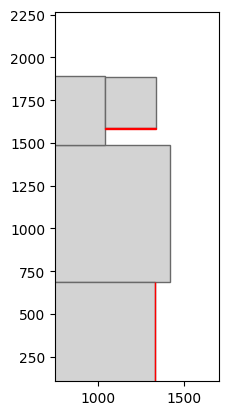

1188.414968331298


In [130]:
Image_out = True
final =calculate_objectives(data, pop[0].genome)
print(final)

NSGA-II

In [131]:
class Agent:
    _pop = []
    
    def __init__(self, genome=None):
        if genome:
            self.genome = np.array(genome)
        else:
            self.genome = np.random.randint(gene_Domain[0], gene_Domain[1], nGene+1)

            # compute 
            self.fitness = np.array(calculate_objectives(data, self.genome)[0:2])
            Agent._pop.append(self)
            
    @classmethod
    def run(cls):
        for _ in range(nPop):
            cls()
        
        # generations
        for it in range(nGeneration):
            # random selection and Crossover
            candidates = sample(cls._pop, nCrossover)
            for i in range(0, nCrossover, 2):
                parent1 = candidates[i]
                parent2 = candidates[i+1]
                parent1.blend_crossover(parent2)

            # random selection and mutation (parent + child)
            candidates = sample(cls._pop, nMutation)
            for i in candidates:
                i.mutate()

            #non_dominated sortings (fronts)
            ndf = cls.non_dominated_sortings()

            cls.cd(ndf)
            
            #sort the population
            cls.sort_population()
            
            #truncate
            cls._pop = cls._pop[:nPop]
            
            # filter the front
            first_front = np.array([i.fitness for i in cls._pop if i.rank == 1])
            
            # plot the costs
            plt.scatter(first_front[:,0], first_front[:,1])
            first_front = np.array(sorted(first_front, key=lambda t: t[0]))
            plt.plot(first_front[:,0], first_front[:,1],"r--")
            plt.show()


    @classmethod
    def non_dominated_sortings(cls):
        c = 1
        nds = {"front1":[]}
        n = len(cls._pop)
        
        for i in cls._pop:
            i.domination_list = []
            i.dominated_count = 0
            i.rank = None
        
        # compute the domination list & domination count
        for i,j in combinations(range(n), 2):
            data1 = cls._pop[i]
            data2 = cls._pop[j]
            
            if all(data1.fitness <= data2.fitness) and any(data1.fitness < data2.fitness):
                # data1 dominates data2
                data1.domination_list.append(j)
                data2.dominated_count += 1
                
            elif all(data2.fitness <= data1.fitness) and any(data2.fitness < data1.fitness):
                # data2 dominates data1
                data2.domination_list.append(i)
                data1.dominated_count += 1
            
        # compute the rank
        for i in range(n):
            if cls._pop[i].dominated_count == 0:
                nds["front1"].append(i)
                cls._pop[i].rank = 1
        
        while True:
            c += 1
            nds[f"front{c}"] = []

            for i in nds[f"front{c-1}"]:
                data1 = cls._pop[i]
                for j in data1.domination_list:
                    data2 = cls._pop[j]
                    data2.dominated_count -= 1
                    if data2.dominated_count == 0:
                        nds[f"front{c}"].append(j)
                        data2.rank = c
            
            if len(nds[f"front{c}"]) == 0:
                del nds[f"front{c}"]
                break
        
        return nds         
    
    @classmethod
    def cd(cls, fronts):
        # crowding distance value
        for i in cls._pop:
            i.crowding_distance = None
        
        for front in fronts.values():
            n = len(front)
            
            if n>1:
                
                costs = np.vstack([cls._pop[k].fitness for k in front])
                d = np.zeros((n, nObjectives))
                
                for j in range(nObjectives):
                    c = np.sort(costs[:,j])
                    idx = np.argsort(costs[:,j])
                    
                    d[idx[0]][j] = np.inf
                    d[idx[-1]][j] = np.inf
                    
                    for i in range(1,n-1):
                        d[idx[i]][j] = np.abs(c[i+1] - c[i-1]) / np.abs(c[0] - c[1])
                 
                
                # compute total crowding distance
                for i,j in enumerate(front):
                    cls._pop[j].crowding_distance = np.sum(d[i,:])
                
            else:
                cls._pop[front[0]].crowding_distance = np.inf

    @classmethod
    def sort_population(cls):
        # first we sort based on crowding distance
        # and then we sort based on front
        cls._pop = sorted(cls._pop, key=lambda t: t.crowding_distance, reverse=True)
        cls._pop = sorted(cls._pop, key=lambda t: t.rank)
    
    def blend_crossover(self,other):
        gamma = np.random.uniform(-alpha, 1+alpha, nGene)
        offspring1 = gamma * self.genome + (1-gamma)*other.genome
        offspring2 = gamma * other.genome + (1-gamma)*self.genome
        
        # bound the offspring's gene to the defined domain
        offspring1[offspring1>gene_Domain[1]] = gene_Domain[1]
        offspring1[offspring1<gene_Domain[0]] = gene_Domain[0]
        offspring2[offspring2>gene_Domain[1]] = gene_Domain[1]
        offspring2[offspring2<gene_Domain[0]] = gene_Domain[0]
        
        [Agent(list(offspring1)), Agent(list(offspring2))]

    def blend_crossover(self,other):
        gamma = np.random.uniform(-alpha, 1+alpha, nGene)
        offspring1 = gamma * self.genome + (1-gamma)*other.genome
        offspring2 = gamma * other.genome + (1-gamma)*self.genome
        
        # bound the offsprings gene to the defined domain
        offspring1[offspring1>gene_Domain[1]] = gene_Domain[1]
        offspring1[offspring1<gene_Domain[0]] = gene_Domain[0]
        offspring2[offspring2>gene_Domain[1]] = gene_Domain[1]
        offspring2[offspring2<gene_Domain[0]] = gene_Domain[0]
        
        [Agent(list(offspring1)), Agent(list(offspring2))]
    
    def mutate(self):
        temp_genome = deepcopy(self.genome)
        sigma = (gene_Domain[1] - gene_Domain[0]) / beta
        temp_genome[np.random.randint(0,nGene)] += np.random.normal(0,sigma)
        
        # bound the mutations individual to the defined value
        temp_genome[temp_genome>gene_Domain[1]] = gene_Domain[1]
        temp_genome[temp_genome<gene_Domain[0]] = gene_Domain[0]

In [132]:
#Agent.run()